In [2]:
!pip install -r req.txt

    100% |████████████████████████████████| 51kB 113kB/s ta 0:00:01
    100% |████████████████████████████████| 696kB 356kB/s ta 0:00:01
    100% |████████████████████████████████| 71kB 281kB/s ta 0:00:01
    100% |████████████████████████████████| 102kB 734kB/s a 0:00:01
    100% |████████████████████████████████| 71kB 1.1MB/s ta 0:00:01
    100% |████████████████████████████████| 13.8MB 409kB/s ta 0:00:011
    100% |████████████████████████████████| 26.3MB 606kB/s ta 0:00:011   62% |████████████████████▏           | 16.5MB 492kB/s eta 0:00:20
    100% |████████████████████████████████| 12.6MB 970kB/s ta 0:00:01
    100% |████████████████████████████████| 215kB 688kB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 1.6MB/s ta 0:00:01
    100% |████████████████████████████████| 71kB 1.8MB/s ta 0:00:01
    100% |████████████████████████████████| 2.1MB 507kB/s ta 0:00:01
    100% |████████████████████████████████| 92kB 1.4MB/s ta 0:00:01


    100% |████████████████████████████████| 102kB 1.1MB/s a 0:00:01
    100% |████████████████████████████████| 102kB 1.9MB/s a 0:00:01
    100% |████████████████████████████████| 81kB 1.7MB/s ta 0:00:01
    100% |████████████████████████████████| 81kB 1.5MB/s ta 0:00:01
    100% |████████████████████████████████| 143kB 1.5MB/s ta 0:00:01
  Stored in directory: /home/deepanshu/.cache/pip/wheels/0a/3c/83/fe2a541de7b1a999b2e6fc7443fcdb49afc5b6664574063186
  Stored in directory: /home/deepanshu/.cache/pip/wheels/b6/c6/31/c20321a5a3fde456fc375b7c2814135e6e98bc0d74c40239d9
  Stored in directory: /home/deepanshu/.cache/pip/wheels/82/e5/de/d90d0f397648a1b58ffeea1b5742ac8c77f71fd43b550fa5a5
  Stored in directory: /home/deepanshu/.cache/pip/wheels/9e/3d/a2/1bec8bb7db80ab3216dbc33092bb7ccd0debfb8ba42b5668d5
Successfully built gcsfs grpc-google-iam-v1 paho-mqtt googleapis-common-protos
distributed 1.21.8 requires msgpack, which is not installed.
  Found existing installation: dask 0.17.5
    Unin

In [3]:
import json
import os
import gcsfs
import numpy as np
import pandas as pd
import time
import google.cloud.bigquery
import datetime
import random
import ssl
import jwt
import paho.mqtt.client as mqtt
import pandas as pd
import json
import sys

In [43]:
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.serialization import load_pem_private_key

In [51]:
GOOGLE_CLOUD_PROJECT = 'smart-meter-242419'
GOOGLE_APPLICATION_CREDENTIALS = 'e2e_demo_credential.json' 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = GOOGLE_APPLICATION_CREDENTIALS

# IoT related
REGION = 'us-central1'
REGISTRY_ID = 'smart_meter123456'
DEVICE_IDS = ['your-device-id1', 'your-device-id2']
PRIVATE_KEY_PATH = 'rs256.key'
CA_CERTIFICATES_PATH = 'roots.pem'

# data related
POWER_DATA_PATH = 'gs://gcp_blog/e2e_demo/test.csv'
DATASET_ID = 'EnergyDisaggregation'

In [17]:
def load_data(project, path):
    fs = gcsfs.GCSFileSystem(project)
    with fs.open(path) as f:
        power_data = pd.read_csv(f, index_col=0)['gross']
    return power_data

In [18]:
MAXIMUM_BACKOFF_TIME = 32

In [64]:
class Publisher:
    """Publish power data every n seconds."""

    # The initial backoff time after a disconnection occurs, in seconds.
    minimum_backoff_time = 1

    # Whether to wait with exponential backoff before publishing.
    should_backoff = False

    def __init__(self,
            project_id,
            region,
            registry_id,
            device_id,
            private_key_path,
            jwt_algorithm,
            jwt_exp_mins,
            ca_certs_path,
            mqtt_bridge_hostname,
            mqtt_bridge_port,
            seq_len,
            sub_topic='events',
            interval=1):
        self.project_id = project_id
        self.region = region
        self.registry_id = registry_id
        self.device_id = device_id
        self.private_key_path = private_key_path
        self.jwt_algorithm = jwt_algorithm
        self.jwt_exp_mins = jwt_exp_mins
        self.ca_certs_path = ca_certs_path
        self.mqtt_bridge_hostname = mqtt_bridge_hostname
        self.mqtt_bridge_port = mqtt_bridge_port
        self.seq_len=seq_len
        self.sub_topic = sub_topic
        self.interval = interval

        self._count = 0
        self._data = {}
        self._mqtt_topic = '/devices/{}/{}'.format(self.device_id, self.sub_topic)
        self._jwt_iat = datetime.datetime.utcnow()
        self._active = False


    def create_jwt(self):
        """Creates a JWT (https://jwt.io) to establish an MQTT connection.
            Returns:
                An MQTT generated from the given project_id and private key, which
                expires in 20 minutes. After 20 minutes, your client will be
                disconnected, and a new JWT will have to be generated.
            Raises:
                ValueError: If the private_key_file does not contain a known key.
            """
        token = {
                # The time that the token was issued at
                'iat': datetime.datetime.utcnow(),
                # The time the token expires.
                'exp': datetime.datetime.utcnow() + datetime.timedelta(minutes=60),
                # The audience field should always be set to the GCP project id.
                'aud': self.project_id
        }

        # Read the private key file.
#         with open(self.private_key_path, 'r') as f:
#             private_key_raw = f.read()

        print('Creating JWT using {} from private key file {}'.format(
                self.jwt_algorithm, self.private_key_path))

        private_key = load_pem_private_key(open(self.private_key_path, 'rb').read(), password='smart'.encode(), backend=default_backend())
        return jwt.encode(token, private_key, algorithm=self.jwt_algorithm)

    def get_client(self):
        """Create our MQTT client. The client_id is a unique string that identifies
        this device. For Google Cloud IoT Core, it must be in the format below."""
        client = mqtt.Client(
                client_id=('projects/{}/locations/{}/registries/{}/devices/{}'
                           .format(
                                   self.project_id,
                                   self.region,
                                   self.registry_id,
                                   self.device_id)))

        # With Google Cloud IoT Core, the username field is ignored, and the
        # password field is used to transmit a JWT to authorize the device.
        client.username_pw_set(
                username='unused',
                password=self.create_jwt())

        # Enable SSL/TLS support.
        client.tls_set(ca_certs=self.ca_certs_path, tls_version=ssl.PROTOCOL_TLSv1_2)

        # Register message callbacks. https://eclipse.org/paho/clients/python/docs/
        # describes additional callbacks that Paho supports.
        client.on_connect = self.on_connect
        client.on_publish = self.on_publish
        client.on_disconnect = self.on_disconnect
        
        return client

    def publish(self):
        # Finish if inactive
        if not self._active:
            return

        # Process network events.
        self.client.loop()

        # Wait if backoff is required.
        if Publisher.should_backoff:
            # If backoff time is too large, give up.
            if Publisher.minimum_backoff_time > MAXIMUM_BACKOFF_TIME:
                print('Exceeded maximum backoff time. Giving up.')
                return
            # Otherwise, wait and connect again.
            delay = Publisher.minimum_backoff_time + random.randint(0, 1000) / 1000.0
            print('Waiting for {} before reconnecting.'.format(delay))
            time.sleep(delay)
            Publisher.minimum_backoff_time *= 2
            self.client.connect(self.mqtt_bridge_hostname, self.mqtt_bridge_port)

        # Refresh token if JWT iat has been expired.
        seconds_since_issue = (datetime.datetime.utcnow() - self._jwt_iat).seconds
        if seconds_since_issue > 60 * self.jwt_exp_mins:
            print('Refreshing token after {}s').format(seconds_since_issue)
            self._jwt_iat = datetime.datetime.utcnow()
            self.client = self.get_client()

        # Generate payload
        d, t = self._data[self._count]
        Publisher.rotate_message(self._msg, d, t)
        payload = json.dumps(self._msg).encode('utf-8')

        # Publish "payload" to the MQTT topic. qos=1 means at least once
        # delivery. Cloud IoT Core also supports qos=0 for at most once
        # delivery.
        self.client.publish(self._mqtt_topic, payload, qos=1)
        print('Published: #{0:03d} on {1} sent: ({2}, {3}).'.format(self._count+1, self.device_id, self._msg['power'][-1], self._msg['timestamp'][-1]))
        self._count += 1

    def start(self, data, start_time=None, cnt=0):
        """Publish payloads to the MQTT topic.
            Args:
             data: pandas.DataFrame, active power data.
             interval: int, time in second.
             start_time: str, publish data collected from start_time.
             cnt: int, number of data records to publish. If cnt<=0, publish all.
            """
        data = Publisher.trim_data(data, start_time)
        self.client = self.get_client()

        data_info = data.values.tolist()
        time_info = data.index.values.tolist()
        self._data = zip(data_info[self.seq_len-1:], time_info[self.seq_len-1:])
        self._msg = {'device_id': self.device_id, 'power': [0] + data_info[:self.seq_len-1],
            'timestamp': [0] + time_info[:self.seq_len-1]}
        self._active = True

        self.client.loop_start()
        
        # Connect to the Google MQTT bridge.
        self.client.connect(self.mqtt_bridge_hostname, self.mqtt_bridge_port)
    
    def stop(self):
        print("Stop loop")
        self._active = False
        self.client.loop_stop()
        self.client.disconnect()

    @staticmethod
    def rotate_message(msg, data, time):
        """Rotate msg according to the prescribed rule.
            Args:
             msg: dict,
             data: int, active power data.
             time: str, the time of measurement
            Returns: Payload for use in publishing
            """
        msg['power'].pop(0)
        msg['power'].append(data)
        msg['timestamp'].pop(0)
        msg['timestamp'].append(time)

    @staticmethod
    def trim_data(data, start_time):
        """Trims data with start time.
            Args:
             data: pandas.DataFrame, active power data.
             start_time: str, publish data collected from start_time.
            Returns: Trimmed data
            """
        if start_time is not None:
            print('before data trimming: data.shape={}'.format(data.shape))
            data = data[data.index.values >= start_time]
            print('after data trimming: data.shape={}'.format(data.shape))
        return data

    def error_str(self, rc):
        """Convert a Paho error to a human readable string."""
        return '{}: {}'.format(rc, mqtt.error_string(rc))

    def on_connect(self, unused_client, unused_userdata, unused_flags, rc):
        """Callback for when a device connects."""
        print('connected: {}'.format(mqtt.connack_string(rc)))

        # After a successful connect, reset backoff time and stop backing off.
        Publisher.should_backoff = False
        Publisher.minimum_backoff_time = 1

        # Trigger initial publish
        self.publish()

    def on_disconnect(self, unused_client, unused_userdata, rc):
        """Paho callback for when a device disconnects."""
        print('disconnected because: {}'.format(error_str(rc)))

        # Since a disconnect occurred, the next loop iteration will wait with
        # exponential backoff.
        Publisher.should_backoff = True

    def on_publish(self, unused_client, unused_userdata, unused_mid):
        """Paho callback when a message is sent to the broker."""
        time.sleep(self.interval)
        self.publish()

In [20]:
power_data = load_data(GOOGLE_CLOUD_PROJECT, POWER_DATA_PATH)
print(power_data.shape)

(432000,)


In [67]:
data = power_data
power_data = data[:10]

In [69]:
publishers = []
for device_id in DEVICE_IDS:
    publisher = Publisher(
            project_id=GOOGLE_CLOUD_PROJECT,
            region=REGION,
            registry_id=REGISTRY_ID,
            device_id=device_id,
            private_key_path=PRIVATE_KEY_PATH,
            ca_certs_path=CA_CERTIFICATES_PATH,
            jwt_exp_mins=20,
            jwt_algorithm='RS256',
            mqtt_bridge_hostname='mqtt.googleapis.com',
            mqtt_bridge_port=8883,
            seq_len=20,
            sub_topic='events')

    publisher.start(data=power_data, start_time='2013-09-21 20:18:00')
    print()
    publishers.append(publisher)

# try: 
#     while True:
#         time.sleep(1)
# except KeyboardInterrupt:
#     for publisher in publishers:
#         publisher.stop()

before data trimming: data.shape=(10,)
after data trimming: data.shape=(0,)
Creating JWT using RS256 from private key file rs256.key

before data trimming: data.shape=(10,)
after data trimming: data.shape=(0,)
Creating JWT using RS256 from private key file rs256.key

connected: Connection Accepted.
connected: Connection Accepted.


In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
import json
import numpy as np
import os
import pandas as pd
import pandas_gbq
import seaborn as sns
import time
import queue
from google.cloud import pubsub_v1
from IPython import display

In [74]:
GOOGLE_CLOUD_PROJECT = 'smart-meter-242419' #@param
GOOGLE_APPLICATION_CREDENTIALS = 'e2e_demo_credential.json' #@param
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = GOOGLE_APPLICATION_CREDENTIALS

# data related
DATASET_ID = 'EnergyDisaggregation'

# pubsub related
PRED_TOPIC = 'pred'
SUB_NAME = 'sub1'
DEVICE_ID = 'target-device-to-monitor' #@param

In [75]:
def get_appliance_info(project_id, dataset):
    """Get appliance info from the big query table.
    
    Load appliance info from big query table.
    
    Args:
      project_id: str, google cloud project id.
      dataset: str, name of the dataset.
    Returns:
      pandas.DataFrame, appliance info.
    """
    res = pandas_gbq.read_gbq(
        'SELECT * FROM {}.ApplianceInfo'.format(dataset),
        project_id,
        dialect='legacy')
    return res

def load_ground_truth(project_id, dataset, appliance_id):
    """Load ground-truth data of a specified appliance from big query table.

    Load true appliance status from big query data.

    Args:
        project_id: str, google project id.
        dataset: str, dataset name.
        appliance_id: int, appliance id.
    Returns:
        pandas.DataFrame, ground truth appliance status.
    """
    query = """
    SELECT * FROM {}.ApplianceStatusGroundTruth
    WHERE appliance_id = {}
    ORDER BY time
    """.format(dataset, appliance_id)
    return pandas_gbq.read_gbq(query,
                               project_id,
                               index_col='time',
                               dialect='legacy')

def load_data(project_id, dataset, app_ids):
    """Load ground-truth data from big query table.

    Load true appliance status from big query data.

    Args:
        project_id: str, google project id.
        dataset: str, dataset name.
        app_ids: list, appliances' ids.
    Returns:
        dict, {appliance_id: ground truth data (pandas.DataFrame)}
    """
    print('Loading ground truth data ...')
    gt = {}
    for k in app_ids:
        gt[k] = load_ground_truth(project_id, dataset, k)
    print('Data loaded.')
    return gt


In [76]:
app_info = get_appliance_info(GOOGLE_CLOUD_PROJECT, DATASET_ID)
app_info

,appliance_name,appliance_id
0,running_machine,0
1,washing_machine,1
2,dish_washer,2
3,microwave,3
4,toaster,4
5,kettle,5
6,rice_cooker,6
7,cooker,7


In [77]:
app_id_name_map = {row[1]: row[0] for i, row in app_info.iterrows()}
app_id_name_map

{0: 'running_machine',
 1: 'washing_machine',
 2: 'dish_washer',
 3: 'microwave',
 4: 'toaster',
 5: 'kettle',
 6: 'rice_cooker',
 7: 'cooker'}

In [78]:
ground_truth = load_data(project_id=GOOGLE_CLOUD_PROJECT,
                         dataset=DATASET_ID,
                         app_ids=app_id_name_map.keys())

Loading ground truth data ...
Data loaded.


In [123]:
import random

In [130]:
ls = list(range(423000))
random.shuffle(ls)
ls = [:1000]

In [1]:
newData = {}
for key, df in ground_truth.items():
    df = ground_truth[key]
    print(df)
    break
    newDf = pd.DataFrame(df.columns[1:])
    x = 0
    i = 0
    while i < 1000:
        newDf.append(df.index(ls[i]))
        i += 1
    newData[key] = newDf
newData

NameError: name 'ground_truth' is not defined

In [108]:
class MsgProcesser(object):
    """Subscribe to a pub/sub topic and process incoming messages."""
    
    def __init__(self,
                 project_id,
                 ground_truth,
                 topic_name,
                 subscription_name,
                 app_id_name_map,
                 target_device):
        # member initialization
        self._gt = ground_truth
        self._data = pd.Series(np.zeros(self._gt[0].shape[0]),
                                index=self._gt[0].index)
        print(self._data.shape)
        self._data = self._data[:10]
        self._app_id_to_name = app_id_name_map
        self._target_device = target_device
        self._app_names = [app_id_name_map[k]
                           for k in range(len(app_id_name_map.keys()))]
        self._queue = queue.Queue(maxsize=100000)
        # create subsciprtion
        self._subscriber, self._subscription_path = (
            self.create_subscription(project_id, topic_name, subscription_name))
        self._subscriber.subscribe(self._subscription_path,
                                   callback=self._msg_callback)
        
    def create_subscription(self, project_id, topic_name, subscription_name):
        """Create a subscription in pub/sub.
    
        Before listening to incoming messages, we need to define a subscription.
        This function creates a new subscription only if it does not exist.

        Args:
          project_id: str, google cloud project id.
          topic_name: str, topic name.
          subscription_name: str, name of the new subscription.
        Returns:
          (google.cloud.pubsub_v1.SubscriberClient, topic_path)
        """
        print('Creating subscription "{}" to topic "{}" ...'.format(
            subscription_name, topic_name))
        try:
            subscriber = pubsub_v1.SubscriberClient()
            topic_path = subscriber.topic_path(project_id, topic_name)
            subscription_path = subscriber.subscription_path(
                project_id, subscription_name)
            # if the subscription exists, exception is raised here
            subscription = subscriber.create_subscription(
                subscription_path, topic_path)
            print('Subscription created: {}'.format(subscription))
        except Exception as e:
            print('Subscription "{}" existed.'.format(subscription_name))
        return subscriber, subscription_path
    
    def async_pull_msg(self):
        """Pull messages asynchronously from pub/sub topic."""
        # initialize metrics
        self._metrics = [{'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
                         for k in range(len(self._app_id_to_name))]
        precisions = [0. for k in self._app_id_to_name]
        recalls = [0. for k in self._app_id_to_name]
        # initialize UI
        fig, ax = plt.subplots(1, 1, figsize=(16, 4))
        sns.axes_style('white')
        # receive data and update UI
        print('Listening for messages on {} ...'.format(
          self._subscription_path))
        max_t = None
        while(True):
            # collect data from callback threads
            t, d, probs = self._queue.get()
            if max_t is None:
                max_t = t
            else:
                max_t = max(t, max_t)
            self._data.at[t] = d
            for k in self._app_id_to_name:
                truth = self._gt[k].status.at[t]
                pred = 1 if probs[k] >= 0.5 else 0
                if truth == 1 and pred == 1:
                    self._metrics[k]['TP'] += 1
                elif truth == 0 and pred == 0:
                    self._metrics[k]['TN'] += 1
                elif truth == 1 and pred == 0:
                    self._metrics[k]['FN'] += 1
                else:
                    self._metrics[k]['FP'] += 1
                TP = self._metrics[k]['TP']
                FP = self._metrics[k]['FP']
                FN = self._metrics[k]['FN']
                precisions[k] = (
                  np.nan if TP + FP == 0 else round(1.0 * TP / (TP + FP), 2))
                recalls[k] = (
                  np.nan if TP + FN == 0 else round(1.0 * TP / (TP + FN), 2))
                
            score_matrix = pd.DataFrame({'Precision': precisions,
                                         'Recall': recalls},
                                        index=self._app_names)
                        
            # update view in the main thread
            ax.clear()
            x = max_t.astype('datetime64[h]')
            mask = (self._data.index >= x) & (self._data.index < x + 1)
            ax = sns.lineplot(data=self._data[mask], linewidth=2.5, ax=ax)
            ax.set_xlabel('time')
            ax.set_ylabel('active power')
            ax.set_ylim(bottom=0)
            title = 'Device: {}, Date: {} (UTC)'.format(
              self._target_device, max_t.astype('datetime64[D]'))
            ax.set_title(title)
            display.clear_output(wait=True)
            display.display(plt.gcf())
            display.display(score_matrix)
            break
            
    def _msg_callback(self, message):
        """Pub/sub pull callback."""
        try:
            data = json.loads(message.data.decode('utf-8'))
            device_id = data['device_id']
            if device_id == self._target_device:
              t = np.datetime64(data['time'][-1])
              d = data['data'][-1]
              probs = data['probs']
              self._queue.put((t, d, probs))
        except Exception as e:
            print('Error: {}'.format(e))
        message.ack()

(432000,)
Creating subscription "sub1" to topic "pred" ...
Subscription "sub1" existed.
Listening for messages on projects/smart-meter-242419/subscriptions/sub1 ...


KeyboardInterrupt: 

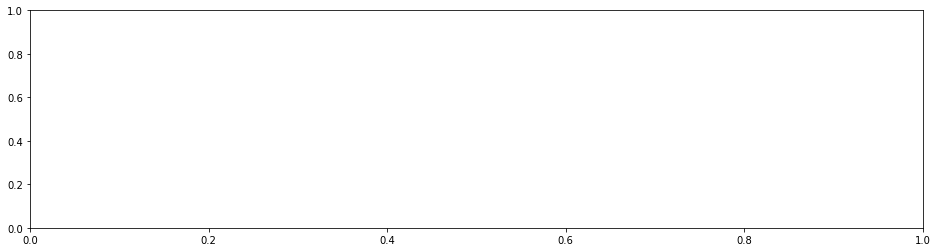

In [96]:
tt = MsgProcesser(project_id=GOOGLE_CLOUD_PROJECT,
                  ground_truth=ground_truth,
                  topic_name=PRED_TOPIC,
                  subscription_name=SUB_NAME,
                  app_id_name_map=app_id_name_map,
                  target_device=DEVICE_ID)
tt.async_pull_msg()
